In [1]:
import io, os, sys, types
import pprint

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC

from sklearn.model_selection import(
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV,
)


from sklearn import preprocessing

from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
)

from sklearn.linear_model import(
    Lasso,
    LassoCV,
    ElasticNet,
    LinearRegression
)

from sklearn.feature_selection import(
    f_regression,
    SelectKBest,
    SelectFromModel
)

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor
)

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

from scipy.stats import skew

import pickle
import xgboost
from sklearn.externals import joblib

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Initializing the dataset
We'll want to apply the same transformations we make on train to test, that way, running a test model won't require going back to make changes to the data. To do this, we'll join the two dataframes.

In [4]:
data = pd.concat(objs=[train, test], axis=0)

# Visualizing Missingness
We'll use a useful tool from the missingno libary to graph NA values. 

UnboundLocalError: local variable 'ax2' referenced before assignment

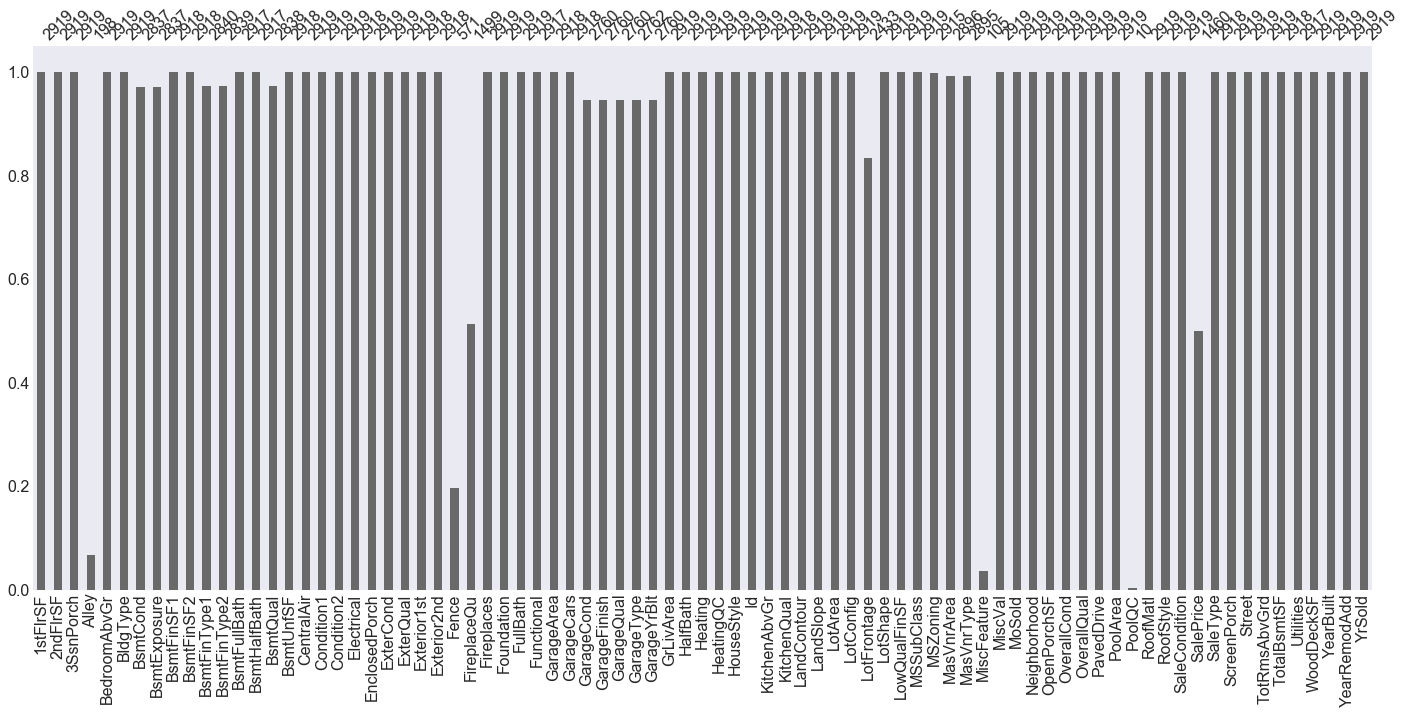

In [38]:
# ax = plt.figure()
msno.bar(data)
# ax.savefig("missing.png", dpi=300)

The reason for Nan values can vary from column to column. Understanding this will help with imputation.

In [ ]:
def return_nas(df):
    return df.columns[df.isnull().any()]
with_nas = return_nas(data)
print("Columns with missing values:\n {}".format(with_nas))
data[with_nas].head()

Some of the columns can have their NA values be converted to 0, an average/median/mode, or a category: "None".  
With others, we can try to get a little clever by looking into the data description.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


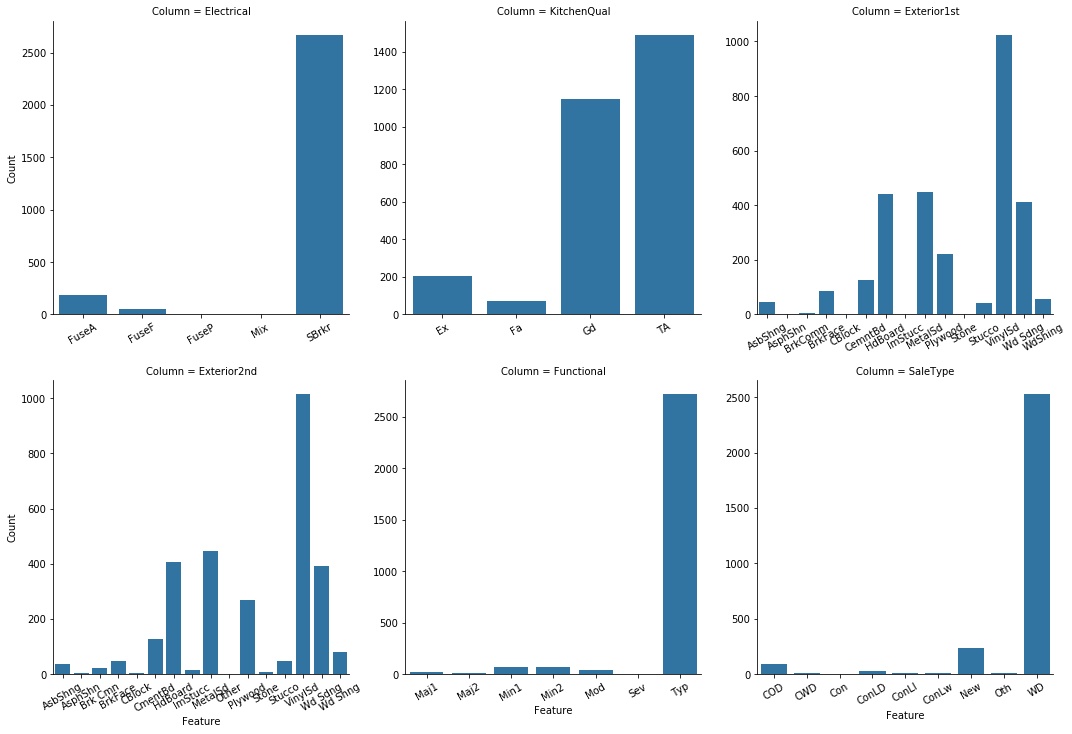

In [5]:
to_mode = [
    "Electrical", "KitchenQual", "Exterior1st",
    "Exterior2nd", "Functional", "SaleType"
]
P = pd.Series()
for i in range(len(to_mode)):
    df = pd.DataFrame(data.groupby(to_mode[i]).size())
    df["Column"] = str(to_mode[i])
    P = pd.concat([P, df], axis=0)
P.reset_index(inplace=True)
P.rename(index=str, columns={"index":"Feature", 0:"Count"}, inplace=True)

g = sns.FacetGrid(P, col="Column", col_wrap = 3, size = 5, sharex=False , sharey=False)
g = g.map(sns.barplot, "Feature", "Count", data=P)
g.fig.tight_layout(h_pad=3.5)
# Label rotation
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)
# plt.savefig("modes.png", dpi=300)

The mode values seem like good guesses for NA values, considering the mode is the overwhelming majority in these features.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

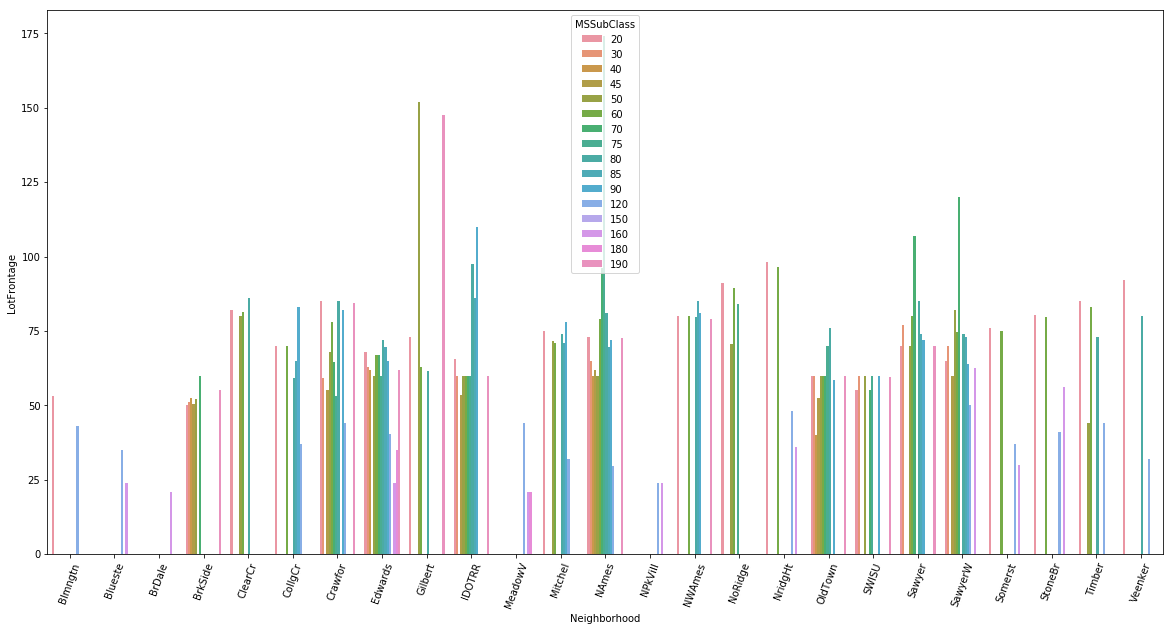

In [28]:
neighborhoods = pd.DataFrame(data.groupby(["Neighborhood","MSSubClass"]).median()["LotFrontage"]).reset_index()
fig = plt.figure(figsize=(20,10))

sns.barplot(x="Neighborhood", y="LotFrontage", hue="MSSubClass",  data=neighborhoods)
plt.xticks(rotation=70)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


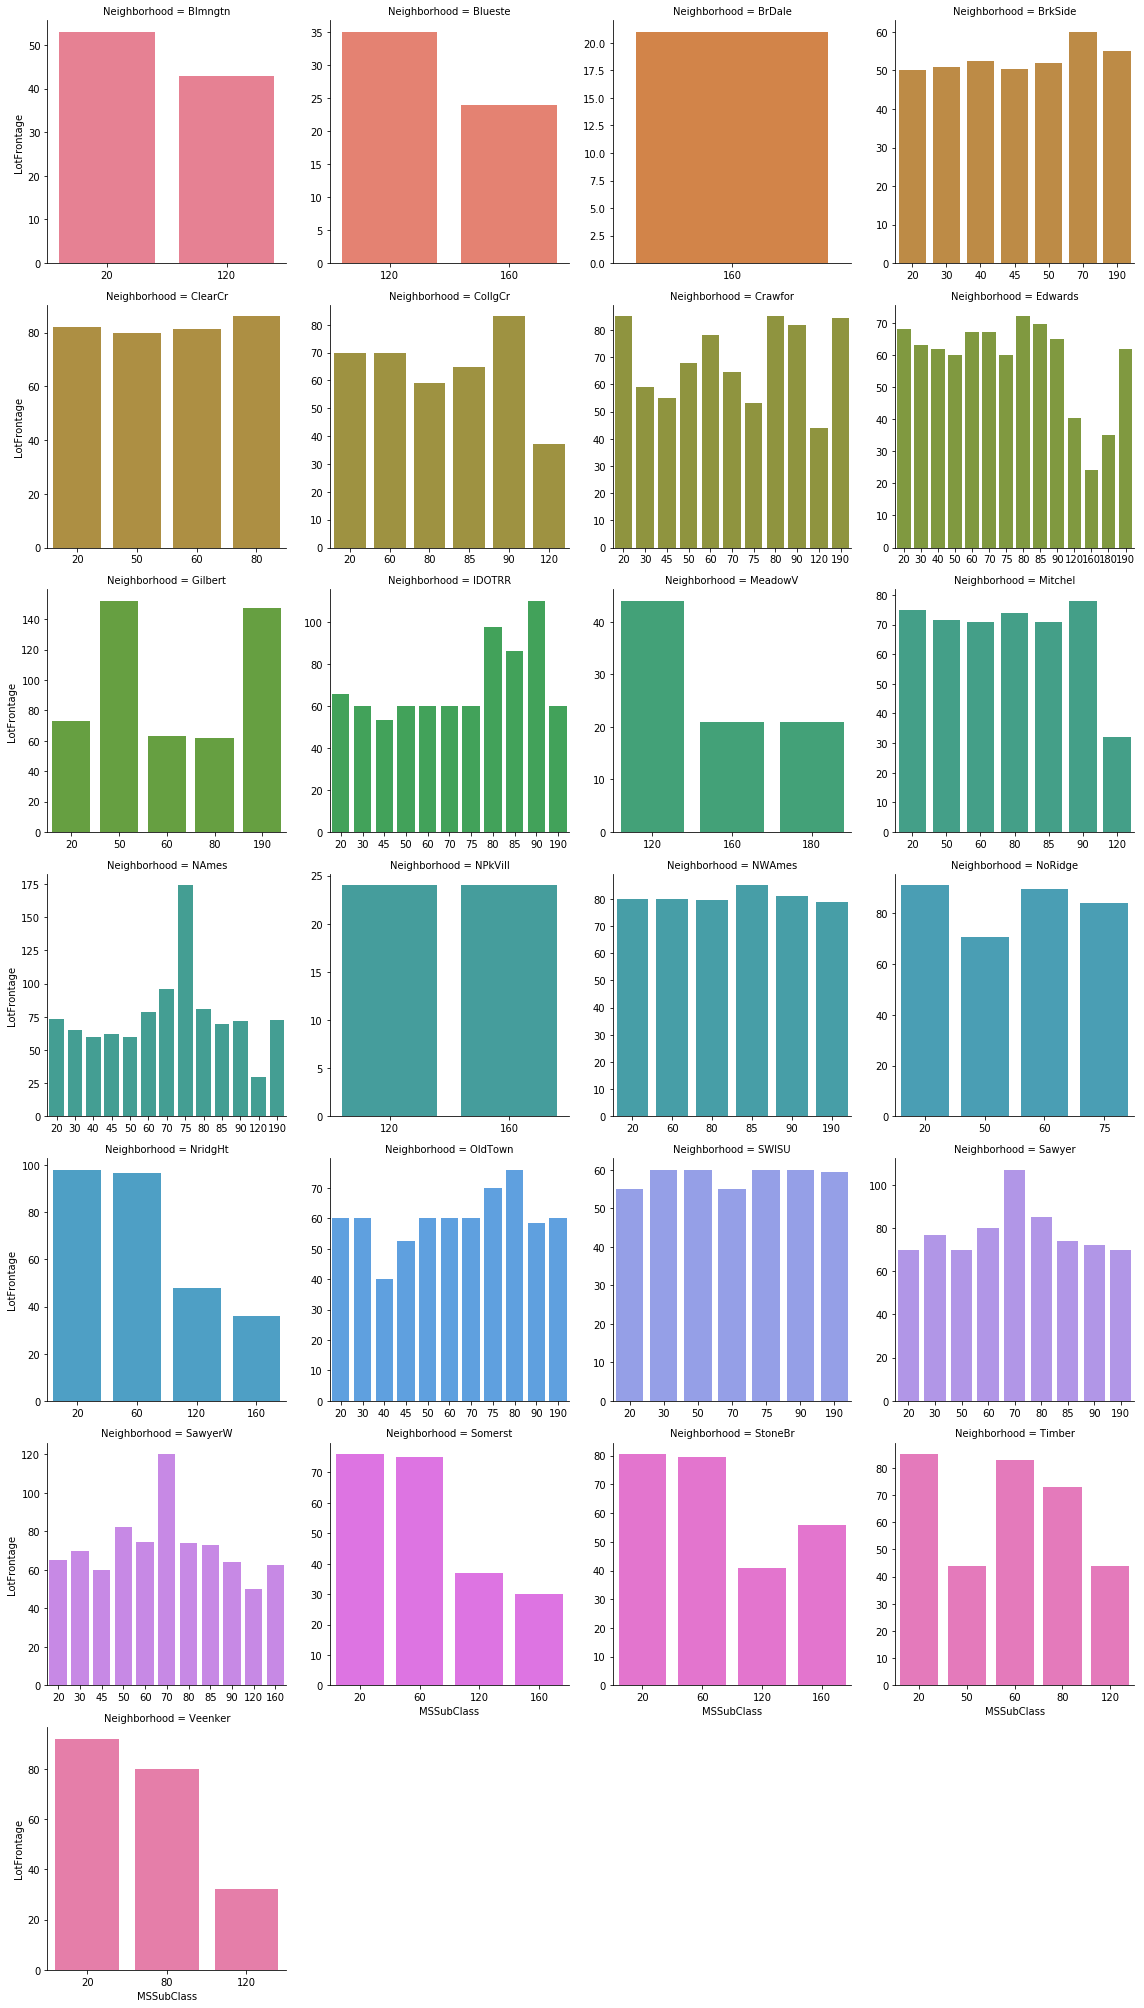

In [34]:
g = sns.FacetGrid(neighborhoods, col = 'Neighborhood' , col_wrap = 4, size = 4,sharex=False , sharey=False, hue="Neighborhood")
g = g.map(sns.barplot, "MSSubClass", "LotFrontage")
g.savefig("neighborhood_lots.png", dpi=300)

In [15]:
to_None = [
    "Alley","BsmtCond", "BsmtExposure",
    "MiscFeature", "PoolQC","Fence",
    "FireplaceQu", "BsmtQual",
    "BsmtFinType1", "BsmtFinType2",
    "GarageType", "GarageFinish",
    "GarageCond", "GarageQual",
    "MasVnrType"
]
data[to_None] = data[to_None].fillna("None", axis=1)

to_0 = [
    "MasVnrArea", "GarageYrBlt", "GarageArea",
    "GarageCars", "BsmtFinSF1", "BsmtFinSF2"
]
data[to_0] = data[to_0].fillna(0, axis=1)

# Convert certain na's to their node values
for col in to_mode:
    data[col] = data[col].fillna(data[col].mode()[0])
        
# Missing GarageYrBlt will have the same year the house was built
data['GarageYrBlt'].fillna(data['YearBuilt'], inplace=True)
# Median lot frontage by neighborhood
data["LotFrontage"].fillna(data.groupby(["Neighborhood","MSSubClass"])["LotFrontage"].transform(
    lambda x: x.fillna(x.median())), inplace=True)

## Detecting outliers
With use of a scatter plot, we can find outliers that won't be helpful for training our model.  
Note: This step is easier to perform before applying any normalization to the data.

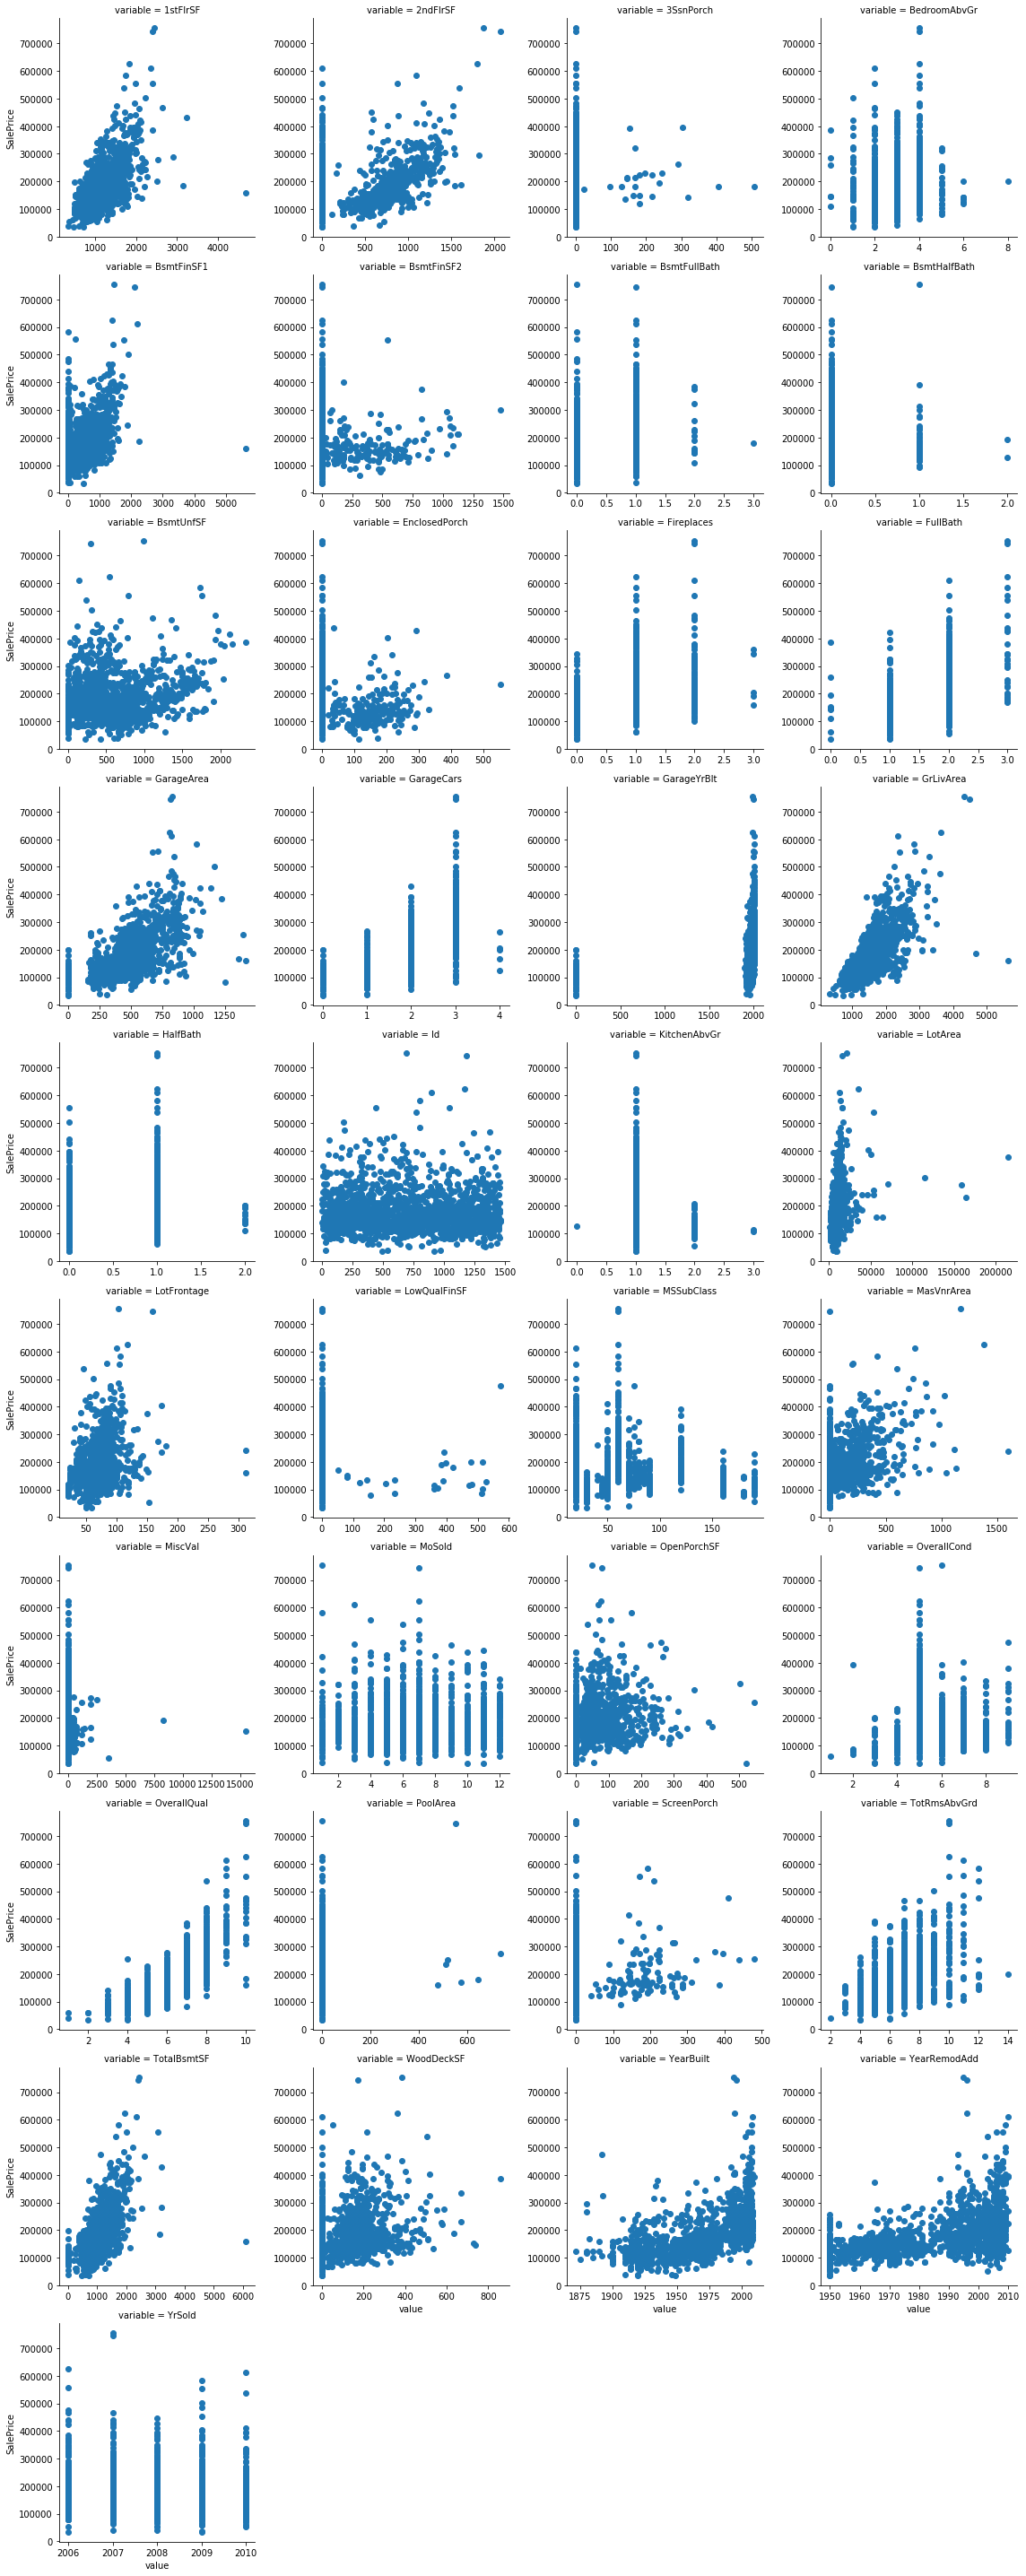

In [16]:
# We'll switch back to the original train dataframe for this visualization
tr = data[data["SalePrice"].isnull() == False]
y = tr["SalePrice"]
tr = tr.select_dtypes(include=['float64', "int64"])
tr.drop("SalePrice", axis=1, inplace=True)

f = pd.melt(pd.concat([tr,y],axis=1) , id_vars = ['SalePrice'] , value_vars = tr.columns )
g = sns.FacetGrid(f, col = 'variable' , col_wrap = 4, size = 4,sharex=False , sharey=False)
g = g.map(plt.scatter, "value", "SalePrice")
g.savefig("regplots_initial.png", dpi=300)

In [ ]:
data = data.drop(data[(data["GrLivArea"] > 4000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['TotalBsmtSF'] > 5000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['MasVnrArea'] > 1500) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['BsmtFinSF1'] > 4000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['LotFrontage'] > 250) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['OpenPorchSF'] > 400) & (data['SalePrice'] < 100000)].index)
data = data.drop(data[(data['1stFlrSF'] > 4000) & (data['SalePrice'] < 200000)].index)

# More Transformation
Some of the features are numerical, but their real value
is in their distinctness from each other- so we can
convert these features to "categorical".   

In [ ]:
 to_category = [
    "Id", "MSSubClass","YrSold", "MoSold",
    "YearBuilt", "YearRemodAdd", "GarageYrBlt",
     "GarageCars", "Fireplaces", "FullBath",
     "HalfBath", "TotRmsAbvGrd", "BsmtFullBath",
     "BsmtHalfBath"
]
for col in to_category:
    data[col] = data[col].astype("str")

We can check for skewed distributions, and normalize them.

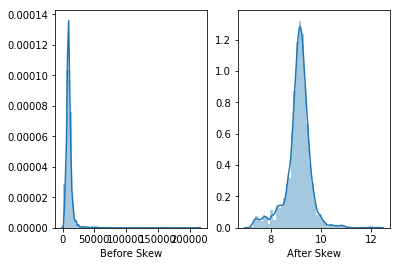

In [9]:
fig, axs = plt.subplots(ncols=2)
before_skew = data["LotArea"]

# Applying logarithmic transform to skewed features
# This code was pulled from Alexandru Papiu:
# https://www.kaggle.com/apapiu/regularized-linear-models

numeric_feats = data.dtypes[data.dtypes != "object"].index
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats.index

log = lambda x: np.log1p(x)
data[skewed_feats] = data[skewed_feats].apply(log)
after_skew = data["LotArea"]
sns.distplot(before_skew, ax=axs[0], axlabel="Before Skew")
sns.distplot(after_skew, ax=axs[1], axlabel="After Skew")
plt.savefig("skew.png", dpi=300)

We are especially interested in making sure the values are distributed normally. A probability plot will assist with this as well.

In [10]:
y = data["SalePrice"].dropna()

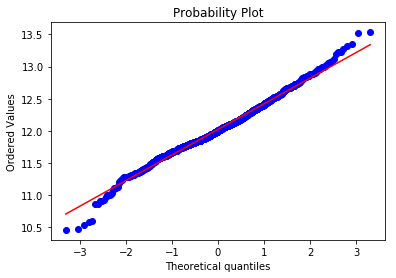

In [11]:
fig = plt.figure()
stats.probplot(y, plot=plt)
plt.show()
plt.savefig("probability_plot.png", dpi=300)

# Dummy Variables and Feature Selection

In [12]:
test = data[data['SalePrice'].isnull()]
# This is where the data is split back into the original data from train.csv
data = data[data['SalePrice'].notnull()]
data.drop("SalePrice", axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [13]:
data = pd.get_dummies(data).fillna(0)

In [14]:
selector = SelectKBest(score_func=f_regression, k=10).fit(data, y)
scores = selector.pvalues_
scores /= scores.max()

ValueError: incompatible sizes: argument 'height' must be length 69 or scalar

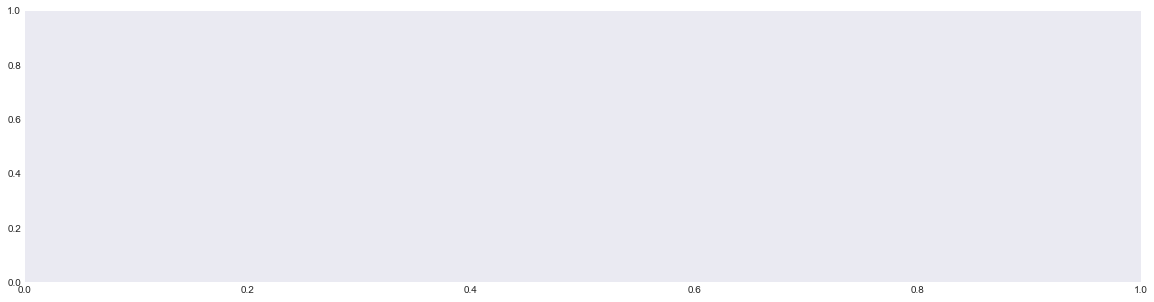

In [35]:
X_indices = np.arange(data.shape[-1])
fig, ax = plt.subplots(figsize = (20,5))
plt.bar(X_indices, (scores), width=10,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black', linewidth=.15)
ax.set_title("P values of dummy dataset")
ax.set_axis_bgcolor("#F7F9F8")
plt.savefig("p_values.png", dpi=300)

Many variables have very high P values, meaning there is little chance they have influence over the Sale Price of the house.

In [16]:
x = np.where(scores <= .05)
data = data[data.columns[x]]
print("Total columns after creating dummy variables and filtering by p-value {}".format(len(data.columns)))

Total columns after creating dummy variables and filtering by p-value 188


# Further feature selection

In [17]:
lasso = LassoCV().fit(data, y)
model = SelectFromModel(lasso, threshold=0.009, prefit=True)
data = data[data.columns[model.get_support()]]
print("Total columns after Lasso feature selection {}".format(data.shape[1]))

Total columns after Lasso feature selection 69


# Understanding the remaining features

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


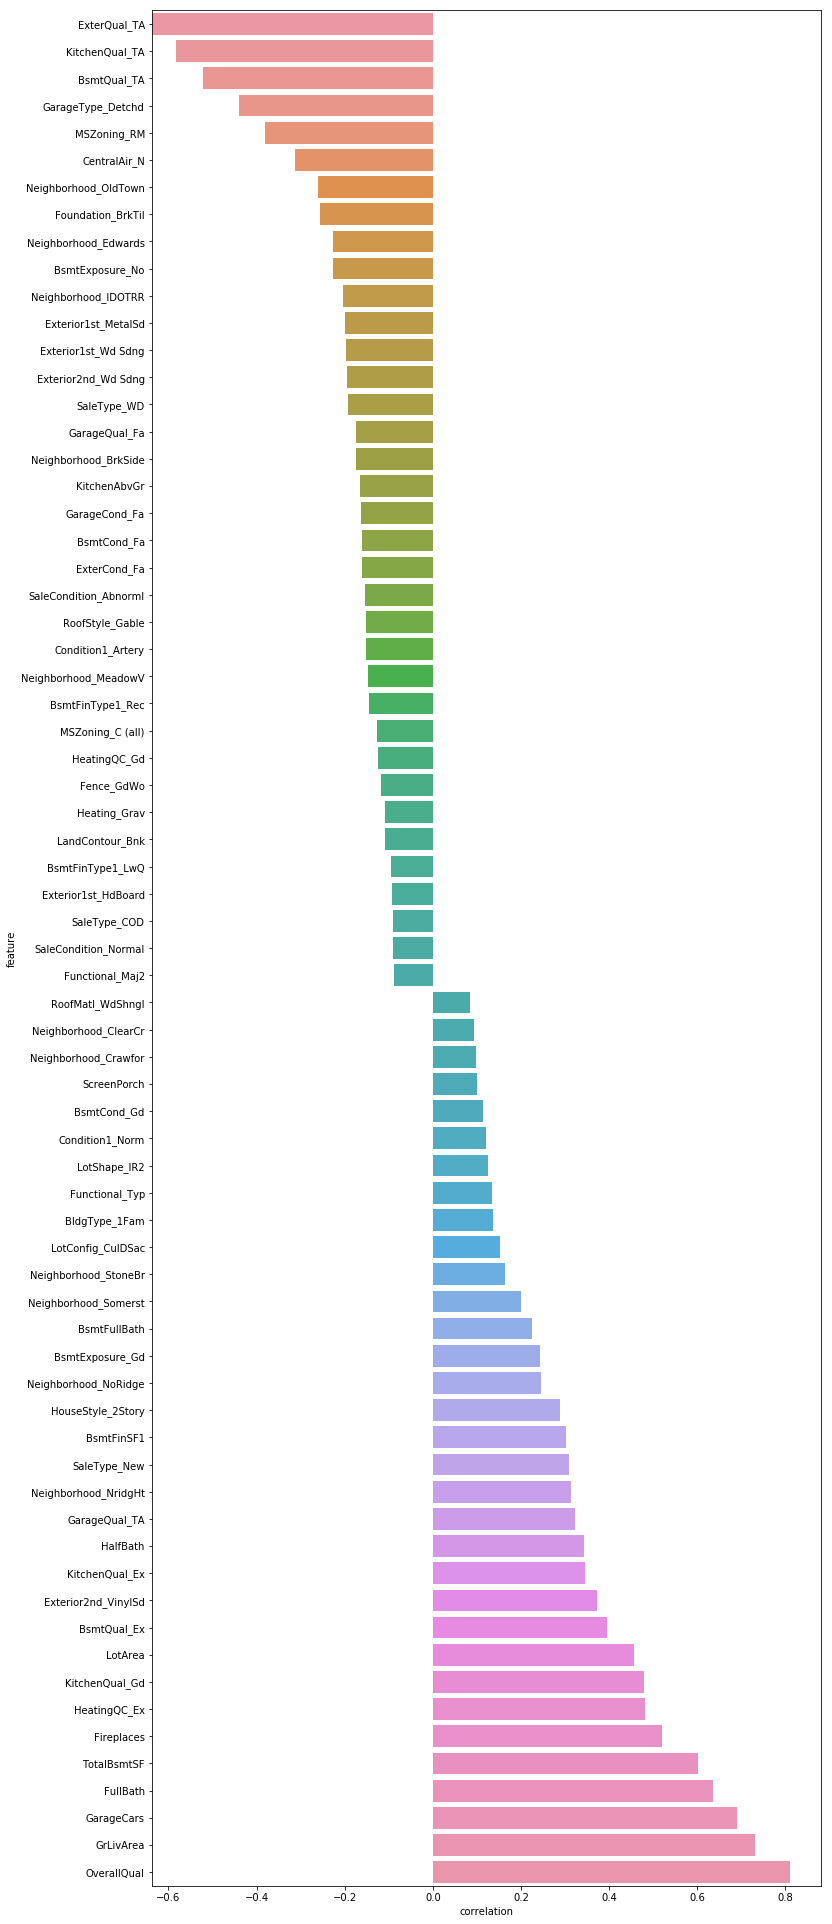

In [18]:
corr_df = pd.DataFrame()
corr_df["correlation"] = [data[feature].corr(y, "spearman") for feature in data.columns]
corr_df["feature"] = data.columns
corr_df = corr_df.sort_values('correlation')

plt.figure(figsize=(12, 0.5*len(corr_df)))
sns.barplot(data=corr_df, y='feature', x='correlation', orient='h')
plt.savefig("corr_spearman.png", dpi=300)

In [19]:
### Correlation Plots
def corrgraphs(df):
    neg = df.corr()[df.corr() < -0.5]
    neg = neg.dropna(how="all", axis=1)
    neg = neg.dropna(how="all", axis=0)
    pos = df.corr()[df.corr() > 0.5]
    pos = pos[pos < 1.0]
    pos = pos.dropna(how="all", axis=1)
    pos = pos.dropna(how="all", axis=0)
    return (neg, pos)
neg, pos = corrgraphs(data)

/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


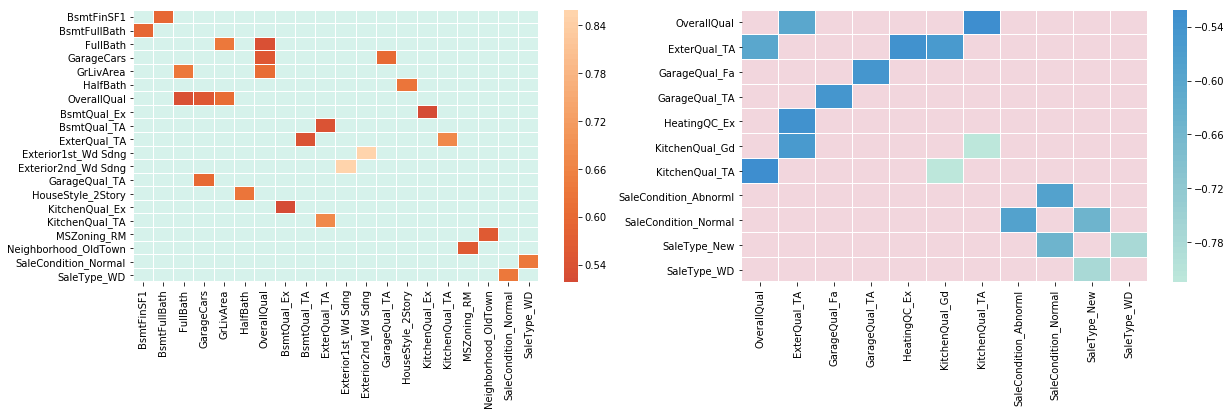

In [20]:
def plot_corrgraphs(neg, pos):
    fig, axs = plt.subplots(ncols=2, figsize=(20,5))
    pos_heatmap = sns.heatmap(pos, center=0, linewidths=0.01, ax=axs[0])
    pos_heatmap.set(axis_bgcolor="#D6F2EB")
    neg_heatmap = sns.heatmap(neg, center=0, linewidths=0.01, ax=axs[1])
    neg_heatmap.set(axis_bgcolor="#F2D6DD")
    return
plot_corrgraphs(neg, pos)
plt.savefig("corrplots.png", dpi=300)

In [21]:
joblib.dump(data, "data.pkl")
joblib.dump(y, "y.pkl")

['y.pkl']

# Modeling

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, y)

# Step 1: Model parameter selection using Grid Search

In [24]:
# Linear Regression
lm = LinearRegression()
lm_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lm = GridSearchCV(estimator=lm,
                       param_grid=lm_parameters,
                       scoring='r2', cv=5,
                       return_train_score=True).fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [25]:
# Lasso
alpha_60 = np.logspace(-2, 5, 60)
lasso_model = Lasso(random_state=24)
lasso_parameters = {'alpha': alpha_60,
                    'fit_intercept': [True, False],
                    "normalize": [True, False],
                    }
grid_lasso = GridSearchCV(estimator=lasso_model,
                          param_grid=lasso_parameters,
                          scoring='r2', cv=5, verbose=0,
                          return_train_score=True).fit(X_train, y_train)

In [26]:
# Elastic Net
alpha_60 = np.logspace(-2, 5, 60)
l1_10 = np.linspace(0.1, 0.9, 9)
elastic_net = ElasticNet(random_state=24)
enet_parameters = [{'alpha': alpha_60, 'l1_ratio': l1_10}]
grid_enet = GridSearchCV(estimator=elastic_net,
                         param_grid=enet_parameters,
                         scoring='r2', cv=5, verbose=0,
                         return_train_score=True).fit(X_train, y_train)


In [27]:
# Random Forest
rf = RandomForestRegressor()

rf_parameters = [{
    "n_estimators": [100, 500],
    "criterion": ["mse"],
    "max_features": ["sqrt"],
    "max_depth": range(9,12),
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=8, dtype=int),
    "oob_score": ["True"],
    "random_state": [24]}]
grid_forest = GridSearchCV(estimator=rf,
                           param_grid=rf_parameters, verbose=0,
                           scoring='r2', cv=5, n_jobs=-1).fit(X_train, y_train)

In [28]:
# XGBoost
xgb_model = xgboost.XGBRegressor()

xgb_parameters = {"colsample_bytree":[0.4,0.5], "gamma":[0.04], 
                  "learning_rate":[0.05], "max_depth":[3,4,5,6,7,8], 
                  "min_child_weight":range(1,5), "n_estimators":[500, 1000],
                  "reg_alpha":[0.4640], "reg_lambda":[0.8571]}

grid_xgb = GridSearchCV(estimator=xgb_model,
                        param_grid=xgb_parameters,
                        n_jobs=3, cv=5,verbose=0, refit=True).fit(X_train, y_train)

In [29]:
bag = BaggingRegressor(base_estimator=grid_enet, n_estimators=10).fit(X_train, y_train) 

models = {
    "Linear": grid_lm,
    "LassoCV": grid_lasso,
    "ElasticNet": grid_enet,
    "RandomForest": grid_forest,
    "XGBoost": grid_xgb,
    "BagRegressor": bag
}

In [30]:
joblib.dump(models, "models.pkl")
# models = joblib.load("models.pkl")

['models.pkl']

# Step 2: Build a RunModels object

In [31]:
class RunModels():
    
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model_dict = {}
    
        # Prints R2 and RMSE scores
    def get_score(self, model, name, pred, y):
        r2score = r2_score(pred, y)
        rmse = np.sqrt(mean_squared_error(pred, y))
        mae = mean_absolute_error(y, pred)
        self.model_dict[name] = {"r2score": r2score,
                                 "RMSE": rmse,
                                 "preds": pred,
                                 "model_params": model}
        print('R-Squared Score: {}'.format(r2score))
        print('Root Mean Square Error: {}'.format(rmse))
        print('Mean Absolute Error: {}'.format(mae))


    # Shows scores for train and validation sets    
    def train_test(self, model, name):
        pred = model.predict(self.X_test)
        self.get_score(model, name, pred, self.y_test)

    def __call__(self, models):
        for name, model in models.items():
            print(name)
            print("-" * len(name))
            self.train_test(model, name)
            print("."*25)
        return self.model_dict

In [32]:
model_scores = RunModels(X_train, y_train, X_test, y_test)(models)

Linear
------
R-Squared Score: 0.877505528551328
Root Mean Square Error: 0.1303683168804305
Mean Absolute Error: 0.09055158382602359
.........................
LassoCV
-------
R-Squared Score: 0.7315929506307031
Root Mean Square Error: 0.16497238841692652
Mean Absolute Error: 0.11192975927348006
.........................
ElasticNet
----------
R-Squared Score: 0.8477722043717527
Root Mean Square Error: 0.1387162427331105
Mean Absolute Error: 0.09529449358259577
.........................
RandomForest
------------
R-Squared Score: 0.7993981739184433
Root Mean Square Error: 0.1455700181420479
Mean Absolute Error: 0.09582534280197964
.........................
XGBoost
-------
R-Squared Score: 0.8665523016417516
Root Mean Square Error: 0.13312592829289402
Mean Absolute Error: 0.09285764394664954
.........................
BagRegressor
------------
R-Squared Score: 0.8450103666432351
Root Mean Square Error: 0.13919332461719958
Mean Absolute Error: 0.09474647117156522
.........................


# Explore results

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


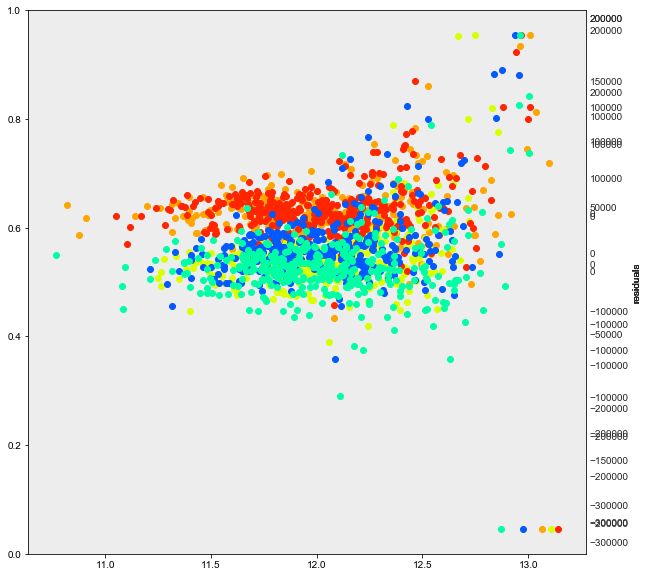

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_bgcolor("#ededed")
sns.set_style("dark")
colors = ["#ffa500","#daff00","#ff2500","#005aff","#00ffa5","#a500ff"]
i = 0
for name, val in model_scores.items():
    if i == len(model_scores) - 1:
        break
    preds = pd.DataFrame({"preds":model_scores[name]["preds"], "true":y_test})
    preds["residuals"] = np.exp(preds["true"]) - np.exp(preds["preds"])
    sns.regplot("preds","residuals", data = preds, ax=ax.twinx(), fit_reg=False,
                ci=0, color=colors[i], scatter_kws={'alpha':1})
    i += 1
plt.savefig("residuals.png", dpi=300)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


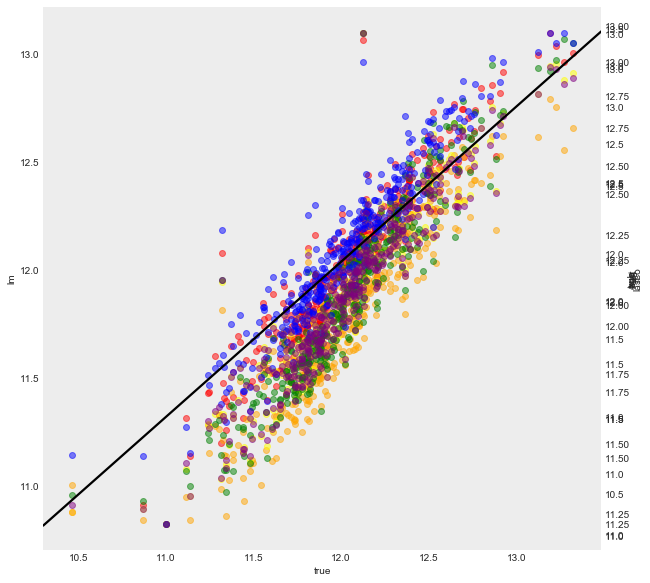

In [34]:
all_preds = pd.DataFrame({"lm": model_scores["Linear"]["preds"],
                          "lasso": model_scores["LassoCV"]["preds"],
                          "enet": model_scores["ElasticNet"]["preds"],
                          "xgb": model_scores["XGBoost"]["preds"],
                          "rf": model_scores["RandomForest"]["preds"],
                          "bag": model_scores["BagRegressor"]["preds"],
                          "true":y_test
                         })
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_bgcolor("#ededed")
sns.regplot(x='true', y='lm', data=all_preds, ax=ax, color="red", fit_reg=False, scatter_kws={'alpha':0.5})
ax2 = ax.twinx()
sns.regplot(x='true', y='lasso', data=all_preds, ax=ax2, color="orange", fit_reg=False, scatter_kws={'alpha':0.5})
ax3 = ax.twinx()
sns.regplot(x='true', y='enet', data=all_preds, ax=ax3, color="yellow", fit_reg=False, scatter_kws={'alpha':0.5})
ax4 = ax.twinx()
sns.regplot(x='true', y='rf', data=all_preds, ax=ax4, color="green", fit_reg=False, scatter_kws={'alpha':0.5})
ax5 = ax.twinx()
sns.regplot(x='true', y='xgb', data=all_preds, ax=ax5, color="blue", fit_reg=False, scatter_kws={'alpha':0.5})
ax6 = ax.twinx()
sns.regplot(x='true', y='bag', data=all_preds, ax=ax6, color="purple", fit_reg=False, scatter_kws={'alpha':0.5})
ax7 = ax.twinx()
sns.regplot(x='true', y='true', data=all_preds, ax=ax7, color="black", fit_reg=True, scatter_kws={'alpha': 0})
plt.savefig("predictions.png", dpi=300)

# Extra Research/ Potential Tools

In [ ]:
# # AdaBoost
# from sklearn.ensemble import AdaBoostRegressor
# ada = AdaBoostRegressor(base_estimator=rf)
# ada.fit(X_train, y_train)
# train_test(ada, X_train, X_test, y_train, y_test)

In [ ]:
# combined_pred = (
#     lm.predict(X_test) +
#     model_xgb.predict(X_test) +
#     bag.predict(X_test) +
#     model_lasso.predict(X_test) +
#     elastic_net.predict(X_test) +
#     gboost.predict(X_test)) / 6
# print('R2: {}'.format(r2_score(combined_pred, y_test)))

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# def vif_filter(df):
#     vif = pd.DataFrame()
#     vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
#     vif["Features"] = df.columns
#     return vif
# vif = vif_filter(data)

# df = train_dummies[vif[vif["VIF Factor"] < 10]["features"]]
# vif
# vif["VIF Factor"] = round(vif["VIF Factor"])
# vif.groupby("VIF Factor").count()["features"] - 1